# HMM inference and MAP estimation in Gilbert-Elliot channel model 
## TensorFlow implementation of Viterbi algorithm and the parallel version of it.

This notebook implements the algorithms from Ref.[2]

[2] S. S. Hassan, S. Särkkä and Á. F. García-Fernández, "__Temporal Parallelization of Inference in Hidden Markov Models__," in *__IEEE Transactions on Signal Processing__*, vol. 69, pp. 4875-4887, 2021, doi: 10.1109/TSP.2021.3103338.



### Imports and utilities

In [1]:
# Python specific imports that will make our job easier and our code prettier
from collections import namedtuple
from functools import partial
import math
import time

# TF specific imports that we will use to code the logic
from tensorflow import function
import tensorflow as tf
import tensorflow_probability as tfp

# Auxiliary libraries that we will use to report results and create the data
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

# Utilities
mm = tf.linalg.matmul
mv = tf.linalg.matvec

# device = '/TPU:0'
device = '/GPU:0'

# check if device is available
# tf.test.is_gpu_available()

### Model

We consider the Gilbert-Elliot channel model. This is  a classical model used in the transmission of signals in digital communication channels. We consider two inputs: one for input signal and another for channel regime signal. They are binary signals and represented by $b_k$ and $s_k$, respectively. 

The input signal $b_k$ is flipped by an idependendent error. We can model this as 
$$
y_k = b_k \oplus v_k
$$

The regime channel signal $s_k$ is represented as two states hidden Markov model, which can have either a good or a bad channel condition. The good state has a low probability error, while the bad state can have a high probability error. If $v_k = 1$ i.e. an error occurs, where $y_k \neq b_k$, then

- $q_0$ represents the probability of the error in the good state.
- $q_1$ represents the probability of the error in the bad state.

The transition probability can be represented as

- $p_0$: transition from high error state (bad state) to low error state (good state).
- $p_1$: transition from low error state (good state) to high error state (bad state).
- $p_2$: switching probability of $b_k$.

The joint model $x_k = (s_k, b_k)$ is a four-state Markov chain. That is,
$$
x_k = \{(0, 0), (0, 1), (1, 0), (1, 1)\}
$$ 
and encoded as $\{0, 1, 2, 3\}$. Our transition and observation matrices are as follows:


$$
\Pi = p(x_k \mid x_{k-1}) = \begin{pmatrix}
(1 - p_0)(1 - p_2) & p_0 (1 - p_2)   & (1 - p_0)p_2        & p_0 p_2 \\  
p_1 (1 - p_2)      & (1-p_1) (1-p_2) & p_1 p_2             & (1- p_1) p_2 \\
(1 - p_0)          & p_0 p_2         & (1 - p_0) (1 - p_2) & p_0  (1 - p_2) \\
p_1 p_2            & (1 - p_1)p_2    & p_1 (1 - p_2)       & (1 - p_1) (1 - p_2)
\end{pmatrix}
$$

and

$$
O = p(y_k\mid x_k) = \begin{pmatrix}
(1 - q_0) & q_0 \\
(1 - q_1) & q_1 \\
q_0 & (1 - q_0) \\
q_1 & (1 - q_1)
\end{pmatrix}
$$





In [2]:
class HMMModel:
    def __init__(self, p0=0.03,  p1=0.1, p2=0.05, q0=0.01, q1=0.1):
        """Gilbert-Elliot channel model.
        
        :math:``
            p0: `P(S_{k+1} = 1 | S_{k} = 0)`
            p1: `P(S_{k+1} = 0 | S_{k} = 1)`
            p2: `P(B_{k+1} = 1 | B_{k} = 0) = P(B_{k+1} = 0 | B_{k} = 1)`
            q0: `P(Y_k != b | B_k = b, S_k = 0)`
            q1: `P(Y_k != b | B_k = b, S_k = 1)`
        
        """
        # transition matrix
        self.np_Pi = np.array([
                               [(1-p0)*(1-p2), p0*(1-p2),     (1-p0)*p2,     p0*p2],
                               [p1*(1-p2),     (1-p1)*(1-p2), p1*p2,         (1-p1)*p2],
                               [(1-p0)*p2,     p0*p2,         (1-p0)*(1-p2), p0*(1-p2)],
                               [p1*p2,         (1-p1)*p2,     p1*(1-p2),     (1-p1)*(1-p2)]
                               ])
        
        # observation matrix
        self.np_Po = np.array([ 
                               [(1-q0), q0],
                               [(1-q1), q1],
                               [q0, (1-q0)],
                               [q1, (1-q1)]
                            ])

        # prior
        self.np_prior = np.array([0.25, 0.25, 0.25, 0.25])

        # convert to tensor
        self.Pi    = tf.convert_to_tensor(self.np_Pi)
        self.Po    = tf.convert_to_tensor(self.np_Po)
        self.prior = tf.convert_to_tensor(self.np_prior)
        
        # dimensions
        self.Pi_dim = self.Pi.shape[-1]
        self.Po_dim = self.Po.shape[-1]
        self.prior_dim = self.prior.shape[-1]

        # transition, observation, and prior in log-space
        self.log_Pi    = tf.math.log(self.Pi)
        self.log_Po    = tf.math.log(self.Po)
        self.log_prior = tf.math.log(self.prior)


In [3]:
def catrnd(rng, p):
    if p.ndim > 1:
        p = p.squeeze()
    
    return rng.choice(p.shape[0], size=1,  p=p)
    

def simulate_data(model: HMMModel, steps:int, seed:int=1):
    rng = np.random.default_rng(seed)
    
    X = np.zeros((steps, 1))
    Y = np.zeros(steps, dtype=np.int64)
    x = catrnd(rng, model.np_prior)
    
    for k in range(steps):
        x = catrnd(rng, model.np_Pi[x])
        y = catrnd(rng, model.np_Po[x])
        X[k] = x
        Y[k] = y
    
    return X, Y


#### Initialize the parameters

In [4]:
log10T = 5
nsteps = 100
T = np.arange(10 ** log10T)+1

#### Initialize the model

In [5]:
model = HMMModel()

#### Simulate the data

In [6]:
X, Y = simulate_data(model,10 ** log10T)

#### Plot the simulated data

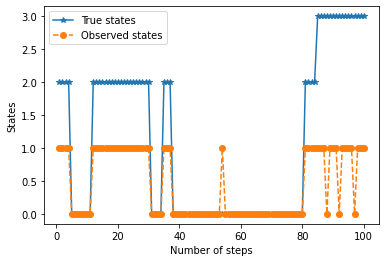

In [7]:
plt.plot(T[:nsteps], X[:nsteps], '*-', T[:nsteps], Y[:nsteps], 'o--')
plt.xlabel('Number of steps')
plt.ylabel('States')
plt.legend(['True states', 'Observed states'])

### Reference implementations for comparison and debugging

In [8]:
def ref_viterbi_classic(model, Y):
    """Reference classical viterbi implementation (path based)
    
    Parameters
    ----------
    model:
        
        HMM model
    Y: array_like
        Observations
    Returns
    -------
    xmap: 
        MAP path
    max_prob: 
        maximum probability
    V_list: 
        probabilities of most probable paths
    u_list: 
        most probable path sequence
    """
    
    
    V_list = np.zeros((Y.shape[0], model.prior_dim, ))
    u_list = np.zeros((Y.shape[0], model.prior_dim, ))
    
    V = model.Po[:, int(Y[0])] * model.prior
    V_list[0] = V
    u = [0] * model.prior.shape[0]
    u_list[0] = u
    for k in range(1, len(Y)):
        psi = model.Po[:, int(Y[k])] * model.Pi
        old_V = V
        V = np.zeros(V.shape)
        u = [0] * V.shape[0]
        for i in range(psi.shape[0]):
            tmp = psi[:, i] * old_V
            u[i] = np.argmax(tmp)
            V[i] = tmp[u[i]]
        V_list[k] = V
        u_list[k] = u
        
    xmap = [0] * len(Y)
    xmap[-1] = np.argmax(V_list[-1])
    max_prob = V_list[-1][xmap[-1]]
    
    for k in reversed(range(len(Y)-1)):
        xmap[k] = int(u_list[k+1][xmap[k+1]])
    
    return xmap, max_prob, V_list, u_list


def ref_viterbi_maxproduct(model, Y):
    """Reference viterbi max-product implementation
    
    Parameters
    ----------
    model: 
        HMM model
    Y: array_like
        Observations
    Returns
    -------
    xmap: 
        MAP path
    max_prob: 
        maximum probability
    V_list: 
        probabilities of most probable paths in forward direction
    W_list: 
        probabilities of most probable paths in reverse direction
    """
    
    
    V_list = np.zeros((Y.shape[0], model.prior_dim, ))
    V = model.Po[:, Y[0]] * model.prior
    V_list[0] = V
    for k in range(1,len(Y)):
        psi = model.Po[:, Y[k]] * model.Pi
        old_V = V
        V = np.zeros(V.shape)
        for i in range(psi.shape[1]):
            tmp = psi[:, i] * old_V
            V[i] = np.max(tmp)
        V_list[k] = V

    W_list = V_list.copy()
    W = np.ones(model.Pi.shape[0])
    W_list[-1] = W
    for k in reversed(range(len(Y)-1)):
        psi = model.Po[:, Y[k+1]] * model.Pi
        
        old_W = W
        W = np.zeros(W.shape)
        for i in range(psi.shape[0]):
            tmp = psi[i, :] * old_W
            W[i] = np.max(tmp)
        W_list[k] = W
    
    xmap = []
    for k in range(len(Y)):
        tmp = V_list[k] * W_list[k]
        ind = np.argmax(tmp)
        max_prob = tmp[ind] # These are all equal
        xmap.append(ind)
        
    return xmap, max_prob, V_list, W_list


#### Reference classical and potential-based Viterbi

In [9]:
ref_xmap1, ref_max_prob1, ref_V_list1, ref_u_list1 = ref_viterbi_classic(model, Y)
ref_xmap2, ref_max_prob2, ref_V_list2, ref_W_list2 = ref_viterbi_maxproduct(model, Y)
print('Difference between classical and max-product based Viterbi: ', max([abs(a-b) for a, b in zip(ref_xmap1, ref_xmap2)]))
print(ref_max_prob1)
print(ref_max_prob2)

Difference between classical and max-product based Viterbi:  3
0.0
0.0


### Plot for reference classical Viterbi implementation

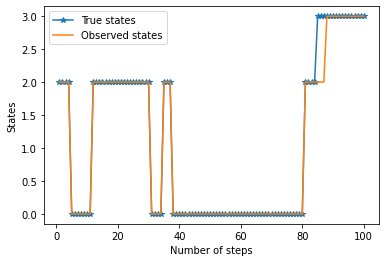

In [10]:
plt.clf()
plt.plot(T[:nsteps], X[:nsteps], '*-', T[:nsteps], [x for x in ref_xmap1[:nsteps]])
plt.xlabel('Number of steps')
plt.ylabel('States')
plt.legend(['True states', 'Observed states'])
plt.show()

### Utilities for log-space computations




In [11]:
@tf.function
def log_mv(log_A, log_b, transpose_a=False):
    Amax = tf.reduce_max(log_A, axis=(-1, -2), keepdims=True)
    bmax = tf.reduce_max(log_b, axis=(-1), keepdims=True)
    return tf.squeeze(Amax,axis=-1) + bmax + tf.math.log(mv(tf.math.exp(log_A - Amax), tf.math.exp(log_b - bmax), transpose_a=transpose_a))

@tf.function
def semilog_mv(A, log_b, transpose_a=False):
    bmax = tf.reduce_max(log_b, axis=(-1), keepdims=True)
    return bmax + tf.math.log(mv(A, tf.math.exp(log_b - bmax), transpose_a=transpose_a))

@tf.function
def log_mm(log_A, log_B, transpose_a=False,transpose_b=False):
    Amax = tf.reduce_max(log_A, axis=(-1, -2), keepdims=True)
    Bmax = tf.reduce_max(log_B, axis=(-1, -2), keepdims=True)
    return Amax + Bmax + tf.math.log(mm(tf.math.exp(log_A - Amax), tf.math.exp(log_B - Bmax), transpose_a=transpose_a, transpose_b=transpose_b))

@tf.function
def log_normalize(log_p):
    pmax = tf.reduce_max(log_p, axis=(-1), keepdims=True)
    temp = tf.math.exp(log_p - pmax)
    return tf.math.log(temp / tf.reduce_sum(temp, axis=-1, keepdims=True))

print('Test utility functions:')
with tf.device('/CPU:0'):
    tf.random.set_seed(5)
    A = tf.random.uniform(shape=[4, 4])
    B = tf.random.uniform(shape=[4, 4])
    log_A = tf.math.log(A)
    log_B = tf.math.log(B)
    print(mm(A, B))
    print(tf.math.exp(log_mm(log_A, log_B)))

    b = tf.random.uniform(shape=[4])
    log_b = tf.math.log(b)
    print(mv(A, b))
    print(tf.math.exp(log_mv(log_A, log_b)))
    print(tf.math.exp(semilog_mv(A, log_b)))

    print(b / tf.reduce_sum(b, keepdims=True))
    print(tf.math.exp(log_normalize(log_b)))


Test utility functions:
tf.Tensor(
[[1.4257064  1.0391585  0.7607688  1.0484284 ]
 [0.9447347  0.76951545 0.44059256 0.6164023 ]
 [0.35811597 0.34018368 0.16159499 0.33705997]
 [0.75753486 0.5810969  0.41004145 0.6656992 ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[1.4257064  1.0391583  0.7607688  1.0484283 ]
 [0.94473475 0.76951534 0.44059253 0.61640227]
 [0.35811597 0.3401837  0.161595   0.33705997]
 [0.75753486 0.58109677 0.41004142 0.6656991 ]], shape=(4, 4), dtype=float32)
tf.Tensor([0.5768026  0.33639905 0.15708235 0.353592  ], shape=(4,), dtype=float32)
tf.Tensor([0.5768026  0.33639905 0.15708235 0.35359204], shape=(4,), dtype=float32)
tf.Tensor([0.5768026  0.3363991  0.15708235 0.35359204], shape=(4,), dtype=float32)
tf.Tensor([0.19298144 0.3319118  0.0531239  0.42198285], shape=(4,), dtype=float32)
tf.Tensor([0.19298144 0.3319118  0.0531239  0.42198288], shape=(4,), dtype=float32)


### Sequential Viterbi in classic and potential forms

#### Classic forward routine

In [12]:
@tf.function
def viterbi_classic_forward_pass(model, obs):
    psi_full = tf.expand_dims(model.Po, 0) * tf.expand_dims(model.Pi, -1)

    def body(carry, y): 
        V, _ = carry
        psi = psi_full[..., y]
        temp = psi * tf.expand_dims(V, -1)
        V = tf.reduce_max(temp, axis=0)
        u = tf.math.argmax(temp, axis=0)
        return (V, u)

    V = model.Po[:, obs[0]] * model.prior
    u = tf.zeros_like(model.prior, dtype=tf.int64)
    Vs, us = tf.scan(body, obs[1:], (V, u))
    Vs = tf.concat([tf.expand_dims(V, 0), Vs], axis=0)
    us = tf.concat([tf.expand_dims(u, 0), us], axis=0)
    return Vs, us



#### Classic backward routine

In [13]:
@tf.function
def viterbi_classic_backward_pass(model, us, Vend):
    def body(carry, u):
        x = carry
        return u[x]

    x = tf.argmax(Vend)
    xs = tf.scan(body, us[1:], x, reverse=True)
    return tf.concat([xs, tf.expand_dims(x, 0)], axis=0)


#### Classic forward-backward routine

In [14]:
@tf.function
def viterbi_classic(model, obs):
    Vs, us = viterbi_classic_forward_pass(model, obs)
    xmap = viterbi_classic_backward_pass(model, us, Vs[-1])
    return xmap



#### Potential-based forward routine

In [15]:
@tf.function
def viterbi_potential_forward_pass(model, obs):
    psi_full = tf.expand_dims(model.Po, 0) * tf.expand_dims(model.Pi, -1)

    def body(carry, y): 
        V = carry
        psi = psi_full[..., y]
        temp = psi * tf.expand_dims(V, -1)
        V = tf.reduce_max(temp, axis=0)
        return V

    V = model.Po[:,obs[0]] * model.prior
    Vs = tf.scan(body, obs[1:], V)
    
    return tf.concat([tf.expand_dims(V, 0), Vs], axis=0)


#### Potential-based backward routine

In [16]:
@tf.function
def viterbi_potential_backward_pass(model, obs):
    psi_full = tf.expand_dims(model.Po, 0) * tf.expand_dims(model.Pi, -1)

    def body(carry, y):
        W = carry
        psi = psi_full[..., y]
        temp = psi * tf.expand_dims(W, 0)
        W = tf.reduce_max(temp, axis=1)
        return W
  
    W  = tf.ones_like(model.prior)
    Ws = tf.scan(body, obs[1:], W, reverse=True)
    return tf.concat([Ws, tf.expand_dims(W, 0)], 0)


#### Potential-based smoother routine

In [17]:
@tf.function
def viterbi_potential_smoother(model, obs):
    Vs = viterbi_potential_forward_pass(model, obs)
    Ws = viterbi_potential_backward_pass(model, obs)
    V = Vs * Ws
    return tf.math.argmax(V,axis=1)

#### Compare classic and potential-based smoother routines

In [18]:
with tf.device('/CPU:0'):
    
    Vs, us = viterbi_classic_forward_pass(model, Y)
    print(np.abs(Vs - tf.convert_to_tensor(ref_V_list1)).max())
    print(np.abs(us - tf.convert_to_tensor(ref_u_list1, dtype=tf.int64)).max())

    xmap = viterbi_classic_backward_pass(model, us, Vs[-1])
    print(np.abs(xmap - tf.convert_to_tensor(ref_xmap1, dtype=tf.int64)).max())
    
    xmap = viterbi_classic(model, Y)
    print(np.abs(xmap - tf.convert_to_tensor(ref_xmap1, dtype=tf.int64)).max())
    
    Vs2 = viterbi_potential_forward_pass(model, Y)
    print(np.abs(Vs2 - Vs).max())
    
    Ws2 = viterbi_potential_backward_pass(model, Y)
    print(np.abs(Ws2 - tf.convert_to_tensor(ref_W_list2)).max())
    
    xmap2 = viterbi_potential_smoother(model, Y)
    print(np.abs(xmap2 - tf.convert_to_tensor(ref_xmap1, dtype=tf.int64)).max())

0.0
3
2
2
0.0
0.0
3


### Log-space sequential Viterbi in classic and potential forms

#### Forward routine

In [19]:
@tf.function
def log_viterbi_classic_forward_pass(model, obs):
    log_psi_full = tf.expand_dims(model.log_Po, 0) + tf.expand_dims(model.log_Pi, -1)

    def body(carry, y): 
        V, _ = carry
        log_psi = log_psi_full[..., y]
        temp = log_psi + tf.expand_dims(V, -1)
        V = tf.reduce_max(temp, axis=0)
        u = tf.math.argmax(temp, axis=0)
        return (V, u)

    V = model.log_Po[:, obs[0]] + model.log_prior
    u = tf.zeros_like(model.log_prior, dtype=tf.int64)
    Vs, us = tf.scan(body, obs[1:], (V, u))
    Vs = tf.concat([tf.expand_dims(V, 0), Vs], axis=0)
    us = tf.concat([tf.expand_dims(u, 0), us], axis=0)
    return Vs, us


#### Backward routine

In [20]:
@tf.function
def log_viterbi_classic_backward_pass(model, us, Vend):
    def body(carry, u):
        x = carry
        return u[x]

    x = tf.argmax(Vend)
    xs = tf.scan(body, us[1:], x, reverse=True)
    return tf.concat([xs, tf.expand_dims(x, 0)], axis=0)


#### Viterbi path routine

In [21]:
@tf.function
def log_viterbi_classic(model, obs, max_parallel=0):
    Vs, us = log_viterbi_classic_forward_pass(model, obs)
    xmap = log_viterbi_classic_backward_pass(model, us, Vs[-1])
    return xmap


#### Potential based forward routine

In [22]:
@tf.function
def log_viterbi_potential_forward_pass(model, obs):
    log_psi_full = tf.expand_dims(model.log_Po, 0) + tf.expand_dims(model.log_Pi, -1)

    def body(carry, y): 
        V = carry
        log_psi = log_psi_full[..., y]
        temp = log_psi + tf.expand_dims(V, -1)
        V = tf.reduce_max(temp, axis=0)
        return V

    V = model.log_Po[:,obs[0]] + model.log_prior
    Vs = tf.scan(body, obs[1:], V)
    
    return tf.concat([tf.expand_dims(V, 0), Vs], axis=0)



#### Potential based backward routine

In [23]:
@tf.function
def log_viterbi_potential_backward_pass(model, obs):
    log_psi_full = tf.expand_dims(model.log_Po, 0) + tf.expand_dims(model.log_Pi, -1)

    def body(carry, y):
        W = carry
        log_psi = log_psi_full[..., y]
        temp = log_psi + tf.expand_dims(W, 0)
        W = tf.reduce_max(temp, axis=1)
        return W
  
    W  = tf.zeros_like(model.log_prior)
    Ws = tf.scan(body, obs[1:], W, reverse=True)
    return tf.concat([Ws, tf.expand_dims(W, 0)], 0)



#### Potential based smoother routine

In [24]:
@tf.function
def log_viterbi_potential_smoother(model, obs, max_parallel=0):
    Vs = log_viterbi_potential_forward_pass(model, obs)
    Ws = log_viterbi_potential_backward_pass(model, obs)
    V = Vs + Ws
    return tf.math.argmax(V,axis=1)

#### Compare the classical and log based Viterbi implementations

In [25]:
with tf.device('/CPU:0'):
    
    Vs, us = viterbi_classic_forward_pass(model, Y)
    log_Vs, log_us = log_viterbi_classic_forward_pass(model, Y)
    print(np.abs(Vs - tf.math.exp(log_Vs)).max())
    print(np.abs(us - log_us).max())
    xmap = viterbi_classic_backward_pass(model, us, Vs[-1])
    log_xmap = log_viterbi_classic_backward_pass(model, log_us, log_Vs[-1])
    print(np.abs(xmap - log_xmap).max())

    Vs2 = viterbi_potential_forward_pass(model, Y)
    log_Vs2 = log_viterbi_potential_forward_pass(model, Y)
    print(np.abs(Vs2 - tf.math.exp(log_Vs2)).max())

    Ws2 = viterbi_potential_backward_pass(model, Y)
    log_Ws2 = log_viterbi_potential_backward_pass(model, Y)
    print(np.abs(Ws2 - tf.math.exp(log_Ws2)).max())

    xmap2 = viterbi_potential_smoother(model, Y)
    log_xmap2 = log_viterbi_potential_smoother(model, Y)
    print(np.abs(xmap2 - log_xmap2).max())
    print(np.abs(log_xmap - log_xmap2).max())


8.326672684688674e-17
3
3
8.326672684688674e-17
1.1102230246251565e-16
3
2


### Parallel Viterbi
We  present  the  tensorflow implementation of parallel  max-product based Viterbi Algorithm 5 described in the paper. 

#### Forward part

#### Initialization routines

In [26]:
@tf.function
def parallel_forward_viterbi_init_first(model, y):
    prior = tf.tile(tf.expand_dims(model.prior, axis=1), [1, model.prior.shape[0]])
    psi = tf.multiply(model.Po[:, y], prior)
    return psi

@tf.function
def parallel_forward_viterbi_init_rest(model, obs):
    temp = tf.gather(tf.transpose(model.Po), obs, axis=0)
    psi = tf.expand_dims(temp, 1) * tf.expand_dims(model.Pi, 0)
    return psi

@tf.function
def parallel_forward_viterbi_init(model, obs):
    first_elem = parallel_forward_viterbi_init_first(model, obs[0])
    generic_elems = parallel_forward_viterbi_init_rest(model, obs[1:])
    return tf.concat([tf.expand_dims(first_elem, 0), generic_elems], axis=0)


#### Parallel forward operator

In [27]:
@tf.function
def parallel_viterbi_op(elemij, elemjk):
    elemij = tf.expand_dims(elemij, -1)
    elemjk = tf.expand_dims(elemjk, 1)
    return tf.reduce_max(elemij * elemjk, axis=2)
  

#### Parallel forward routine

In [28]:
@tf.function
def parallel_forward_viterbi(model, obs,  max_parallel=100000):
    initial_elements = parallel_forward_viterbi_init(model, obs)
    final_elements = tfp.math.scan_associative(parallel_viterbi_op,
                                             initial_elements,
                                             max_num_levels=math.ceil(math.log2(max_parallel)))
    return final_elements[:,0]


#### Backward part

#### Initialization routines

In [29]:
@tf.function
def parallel_backward_viterbi_init_last(model):
    psi = tf.ones_like(model.Pi)
    return psi

@tf.function
def parallel_backward_viterbi_init_rest(model, obs):
    temp = tf.gather(tf.transpose(model.Po), obs, axis=0)
    psi = tf.expand_dims(temp, 1) * tf.expand_dims(model.Pi, 0)
    return psi

@tf.function
def parallel_backward_viterbi_init(model, obs):
    last_elem = parallel_backward_viterbi_init_last(model)
    generic_elems = parallel_backward_viterbi_init_rest(model, obs[1:])
    return tf.concat([generic_elems, tf.expand_dims(last_elem, 0)], axis=0)


#### Backward operator

In [30]:
@tf.function
def parallel_backward_viterbi_op(elemjk, elemij):
    elemij = tf.expand_dims(elemij, -1)
    elemjk = tf.expand_dims(elemjk, 1)
    return tf.reduce_max(elemij * elemjk, axis=2)



#### Parallel backward routine

In [31]:
@tf.function
def parallel_backward_viterbi(model, obs, max_parallel=10000):
    initial_elements = parallel_backward_viterbi_init(model, obs)
    reversed_elements = tf.reverse(initial_elements, axis=[0])
    final_elements = tfp.math.scan_associative(parallel_backward_viterbi_op,
                                             reversed_elements,
                                             max_num_levels=math.ceil(math.log2(max_parallel)))
    final_elements = tf.reverse(final_elements, axis=[0])

    return final_elements[..., 0]


#### Parallel Viterbi path

In [32]:
@tf.function
def parallel_potential_viterbi(model, obs, max_parallel=10000):
    vlist = parallel_forward_viterbi(model, obs, max_parallel)
    wlist = parallel_backward_viterbi(model, obs, max_parallel)

    prob = vlist * wlist
    max_prob = tf.reduce_max(prob)
    xmap = tf.squeeze(tf.math.argmax(prob, axis=1))
    
    return xmap

#### Comparison with sequential and parallel Viterbi implementations

In [33]:
with tf.device('/CPU:0'):
    xmap2 = viterbi_potential_smoother(model, Y)
    xmap3 = viterbi_classic(model, Y)
    xmap = parallel_potential_viterbi(model, Y, max_parallel=100000)
    print('Diff between parallel and sequential potential-based Viterbi path: ', np.abs(xmap - xmap2).max())
    print('Diff between parallel and sequential classical Viterbi path: ', np.abs(xmap - xmap3).max())
    print(np.abs(xmap - tf.convert_to_tensor(ref_xmap1, dtype=tf.int64)).max())
    print(np.abs(xmap2 - tf.convert_to_tensor(ref_xmap1, dtype=tf.int64)).max())
    print(np.abs(xmap3 - tf.convert_to_tensor(ref_xmap1, dtype=tf.int64)).max())

Diff between parallel and sequential potential-based Viterbi path:  0
Diff between parallel and sequential classical Viterbi path:  3
3
3
2


### Log-space parallel Viterbi

#### Forward part
#### Initialization routines

In [34]:
@tf.function
def log_parallel_forward_viterbi_init_first(model, y):
    return tf.math.log(parallel_forward_viterbi_init_first(model, y))

@tf.function
def log_parallel_forward_viterbi_init_rest(model, obs):
    return tf.math.log(parallel_forward_viterbi_init_rest(model, obs))

@tf.function
def log_parallel_forward_viterbi_init(model, obs):
    first_elem = log_parallel_forward_viterbi_init_first(model, obs[0])
    generic_elems = log_parallel_forward_viterbi_init_rest(model, obs[1:])
    return tf.concat([tf.expand_dims(first_elem, 0), generic_elems], axis=0)


#### Viterbi operator

In [35]:
@tf.function
def log_parallel_viterbi_op(elemij, elemjk):
    elemij = tf.expand_dims(elemij, -1)
    elemjk = tf.expand_dims(elemjk, 1)
    return tf.reduce_max(elemij + elemjk, axis=2)


#### Parallel forward routine

In [36]:
@tf.function
def log_parallel_forward_viterbi(model, obs,  max_parallel=100000):
    initial_elements = log_parallel_forward_viterbi_init(model, obs)
    final_elements = tfp.math.scan_associative(log_parallel_viterbi_op,
                                             initial_elements,
                                             max_num_levels=math.ceil(math.log2(max_parallel)))
    return final_elements[:,0]


#### Backward part

#### Initialization routines

In [37]:
@tf.function
def log_parallel_backward_viterbi_init_last(model):
    log_psi = tf.zeros_like(model.log_Pi)
    return log_psi

@tf.function
def log_parallel_backward_viterbi_init_rest(model, obs):
    temp = tf.gather(tf.transpose(model.log_Po), obs, axis=0)
    log_psi = tf.expand_dims(temp, 1) + tf.expand_dims(model.log_Pi, 0)
    return log_psi

@tf.function
def log_parallel_backward_viterbi_init(model, obs):
    last_elem = log_parallel_backward_viterbi_init_last(model)
    generic_elems = log_parallel_backward_viterbi_init_rest(model, obs[1:])
    return tf.concat([generic_elems, tf.expand_dims(last_elem, 0)], axis=0)


#### Backward operator

In [38]:
@tf.function
def log_parallel_backward_viterbi_op(elemjk, elemij):
    elemij = tf.expand_dims(elemij, -1)
    elemjk = tf.expand_dims(elemjk, 1)
    return tf.reduce_max(elemij + elemjk, axis=2)


#### Backward routine

In [39]:
@tf.function
def log_parallel_backward_viterbi(model, obs, max_parallel=100000):
    initial_elements = log_parallel_backward_viterbi_init(model, obs)
    reversed_elements = tf.reverse(initial_elements, axis=[0])
    final_elements = tfp.math.scan_associative(log_parallel_backward_viterbi_op,
                                             reversed_elements,
                                             max_num_levels=math.ceil(math.log2(max_parallel)))
    final_elements = tf.reverse(final_elements, axis=[0])

    return final_elements[..., 0]



#### Parallel potential-based Viterbi forward-backward routine in log-space

In [40]:
@tf.function
def log_parallel_potential_viterbi(model, obs, max_parallel=100000):
    vlist = log_parallel_forward_viterbi(model, obs, max_parallel)
    wlist = log_parallel_backward_viterbi(model, obs, max_parallel)

    prob = vlist + wlist
    max_prob = tf.reduce_max(prob)
    xmap = tf.math.argmax(prob, axis=1)
    
    return xmap

#### Comparison of different Viterbi implementations

In [41]:
with tf.device('/CPU:0'):
    xmap = parallel_potential_viterbi(model, Y, max_parallel=100000)
    log_xmap = log_parallel_potential_viterbi(model, Y, max_parallel=100000)
    log_xmap2 = log_viterbi_potential_smoother(model, Y)
    log_xmap3 = log_viterbi_classic(model, Y)
    log_xmap4 = viterbi_classic(model, Y)
    print(np.abs(xmap - log_xmap).max())
    print(np.abs(log_xmap2 - log_xmap).max())
    print(np.abs(log_xmap3 - log_xmap).max())
    print(np.abs(log_xmap3 - log_xmap2).max())
    print(np.abs(log_xmap4 - log_xmap3).max())


3
2
2
2
3


### Performance analysis

In [ ]:
input_sizes = np.logspace(2, log10T, num=20, base=10).astype(int)
n_iter = 100
n_iter_seq = 10


In [ ]:
def get_average_runtimes(func, n_iter, model, observations):
    runtimes = np.empty(input_sizes.shape)
    for i, input_size in tqdm(enumerate(input_sizes), total=runtimes.shape[0]):
        observation_slice = observations[:input_size]
        max_parallel = int(input_size)
        _ = func(model, observation_slice, max_parallel=max_parallel)  # compilation run
        tic = time.time()
        for _ in trange(n_iter, leave=False):
            res = func(model, observation_slice, max_parallel=max_parallel)
        runtimes[i] = (time.time() - tic) / n_iter
    return runtimes

In [ ]:
with tf.device('/CPU:0'):
    cpu_Y = tf.constant(Y)
    cpu_sequential_runtimes3a = get_average_runtimes(log_viterbi_classic, n_iter_seq, model, cpu_Y)
    cpu_sequential_runtimes3b = get_average_runtimes(log_viterbi_potential_smoother, n_iter_seq, model, cpu_Y)
    cpu_parallel_runtimes3 = get_average_runtimes(log_parallel_potential_viterbi, n_iter, model, cpu_Y)
    
with tf.device(device):
    xpu_Y = tf.constant(Y)
    xpu_sequential_runtimes3a = get_average_runtimes(log_viterbi_classic, n_iter_seq, model, xpu_Y)
    xpu_sequential_runtimes3b = get_average_runtimes(log_viterbi_potential_smoother, n_iter_seq, model, xpu_Y)
    xpu_parallel_runtimes3 = get_average_runtimes(log_parallel_potential_viterbi, n_iter, model, xpu_Y)


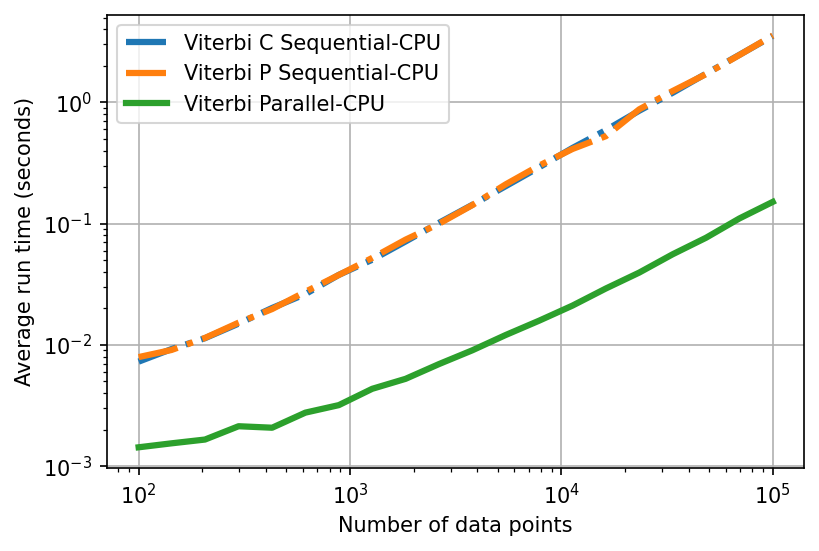

In [ ]:
fig = plt.figure(1, dpi=150)
plt.loglog(input_sizes, cpu_sequential_runtimes3a, label="Viterbi C Sequential-CPU", linestyle="-.", linewidth=3)
plt.loglog(input_sizes, cpu_sequential_runtimes3b, label="Viterbi P Sequential-CPU", linestyle="-.", linewidth=3)
plt.loglog(input_sizes, cpu_parallel_runtimes3, label="Viterbi Parallel-CPU", linewidth=3)
plt.legend()
plt.xlabel("Number of data points")
plt.ylabel("Average run time (seconds)")
plt.grid()
plt.show()

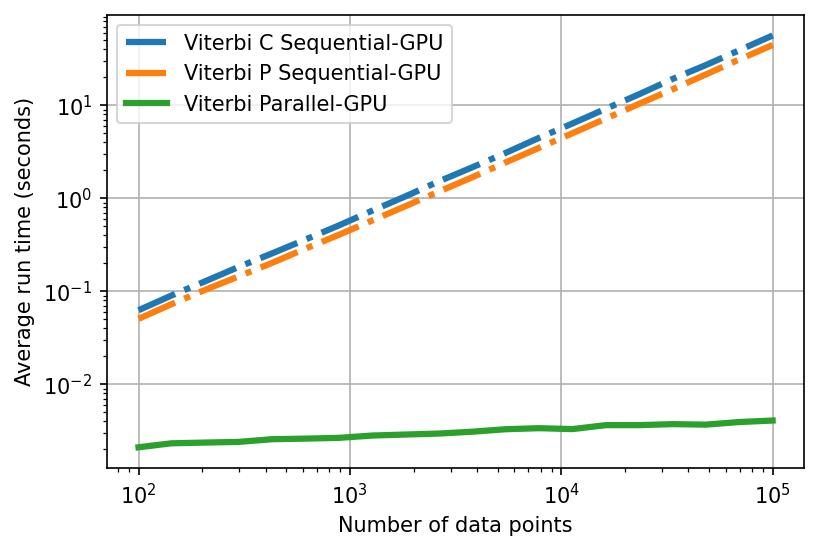

In [ ]:
fig = plt.figure(1, dpi=150)
plt.loglog(input_sizes, xpu_sequential_runtimes3a, label="Viterbi C Sequential-GPU", linestyle="-.", linewidth=3)
plt.loglog(input_sizes, xpu_sequential_runtimes3b, label="Viterbi P Sequential-GPU", linestyle="-.", linewidth=3)
plt.loglog(input_sizes, xpu_parallel_runtimes3, label="Viterbi Parallel-GPU", linewidth=3)
plt.legend()
plt.xlabel("Number of data points")
plt.ylabel("Average run time (seconds)")
plt.grid()
plt.show()